In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import pickle
from functions import evaluate

In [2]:
modelpath = 'C:\\Users\\marca\\OneDrive\\Desktop\\Root Assignment\\work_sample\\model_data.csv'
trippath = 'C:\\Users\\marca\\OneDrive\\Documents\\My Code\\rootproj\\trip_data\\'

In [3]:
import os
import sys
import functions
import time
import pandas as pd

THIS_DIR = os.path.abspath('')

def main(path_to_model_data: str, path_to_trip_data: str) -> None:
    model_data = pd.read_csv(path_to_model_data)
    filenames = []
    stops = []
    turns = []
    os.chdir(path_to_trip_data)
    for file in os.listdir(path_to_trip_data):
        if file.endswith(".csv"):
            trips = pd.read_csv(file)
            timestamps = trips.time_seconds.tolist()
            speeds = trips.speed_meters_per_second.tolist()
            headings = trips.heading_degrees.tolist()
            stop_count = functions.count_of_stops(timestamps, speeds, headings)
            turn_count = functions.count_of_turns(timestamps, speeds, headings)
            
            filenames.append(file)
            stops.append(stop_count)
            turns.append(turn_count)
            
    os.chdir(THIS_DIR)
            
    add_features = pd.DataFrame(list(zip(filenames, stops, turns)), 
               columns =['filename','stops','turns']) 
    df = pd.merge(model_data, add_features, how='left', on='filename', 
                  validate='one_to_one')
    
    return df

In [4]:
df = main(modelpath,trippath)
df.head()

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y,stops,turns
0,0000.csv,False,False,True,5.209096,9789.261511,30753.872048,0.001010,5,13,1,9.373984e+03,0.317920,9.379193e+03,4.974085,0,0,6
1,0001.csv,False,False,False,4.450941,10552.521899,33151.725274,0.001000,3,11,1,4.251619e+04,2.229321,4.252064e+04,3.151531,0,1,10
2,0002.csv,False,False,True,5.396552,10233.433119,32149.278307,0.001015,6,13,1,1.305321e+07,34.259512,1.305322e+07,6.236594,0,0,6
3,0003.csv,False,False,True,4.970163,10829.056746,34020.485118,0.000993,4,8,1,1.131908e+03,25.768714,1.136878e+03,3.968008,1,3,7
4,0004.csv,False,False,False,5.266868,10678.703687,33548.137053,0.001009,6,11,1,3.163256e+03,145.154357,3.168523e+03,5.999782,0,10,7


In [5]:
predictors = [x for x in df.columns if x not in ['y', 'filename']]
#, 'feature10', 'feature2'
X = df[predictors]
y = df['y']

In [6]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.10, random_state=42)

Model Selection

In [7]:
from sklearn.model_selection import cross_validate

lr = LogisticRegression(random_state=10)
rf = RandomForestClassifier(n_estimators=100, random_state=10)
gb = GradientBoostingClassifier(n_estimators=100, random_state=10)
ab = AdaBoostClassifier(n_estimators=100, random_state=10)

lr_results = cross_validate(lr, X, y, cv=5, scoring=('f1'))
rf_results = cross_validate(rf, X, y, cv=5, scoring=('f1'))
gb_results = cross_validate(gb, X, y, cv=5, scoring=('f1'))
ab_results = cross_validate(ab, X, y, cv=5, scoring=('f1'))

print("LR avg F1 score is {}".format(np.mean(lr_results['test_score'])))
print("RF avg F1 score is {}".format(np.mean(rf_results['test_score'])))
print("GB avg F1 score is {}".format(np.mean(gb_results['test_score'])))
print("AB avg F1 score is {}".format(np.mean(ab_results['test_score'])))

LR avg F1 score is 0.4619739955088214
RF avg F1 score is 0.7254319270148335
GB avg F1 score is 0.7563481825178608
AB avg F1 score is 0.718669502590957


Train Baseline GB model

GB score is 0.88


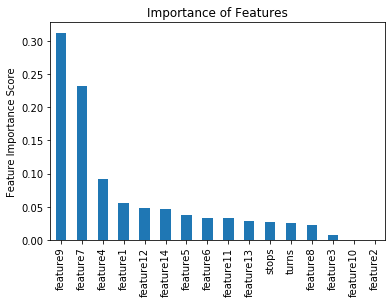

In [8]:
baseline_GB = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=5, 
                                      min_samples_split=4, min_samples_leaf=1, subsample=0.8,
                                      max_features='sqrt', random_state=10)

baseline_GB.fit(train_x,train_y)

feat_imp = pd.Series(baseline_GB.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print("GB score is {}".format(baseline_GB.score(test_x, test_y)))

In [9]:
# Remove zero variance features for tuning
selector = VarianceThreshold()
selector.fit_transform(train_x)

baseline_GB = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=5, 
                                      min_samples_split=4, min_samples_leaf=1, subsample=0.8,
                                      max_features='sqrt', random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',baseline_GB)])
                                   
pipeline.fit(train_x, train_y)

print("GB score is {}".format(pipeline.score(test_x, test_y)))

GB score is 0.91


Tuning Hyperparameters

In [10]:
# n_estimators

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__n_estimators':range(20,200,5)}

gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_split=5, min_samples_leaf=30, subsample=0.8, 
                                max_features='sqrt', random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning1 = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning1.fit(train_x,train_y)

print("The best score is {}".format(tuning1.best_score_))
print("The best hyper parameter setting is {}".format(tuning1.best_params_))

The best score is 0.8555555555555555
The best hyper parameter setting is {'model__n_estimators': 70}


In [11]:
# Max_depth and min_samples_split

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__max_depth':range(2,8,1),'model__min_samples_split':range(5,50,1)}

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 70, min_samples_leaf=30, subsample=0.8,
                                                  max_features='sqrt', random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(train_x,train_y)

print("The best score is {}".format(tuning.best_score_))
print("The best hyper parameter setting is {}".format(tuning.best_params_))

The best score is 0.8588888888888888
The best hyper parameter setting is {'model__max_depth': 7, 'model__min_samples_split': 5}


In [12]:
# min_samples_leaf

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__min_samples_leaf':range(10,71,10)}

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, min_samples_split=5, 
                                max_depth=7, subsample=0.8, max_features='sqrt', random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(train_x,train_y)

print("The best score is {}".format(tuning.best_score_))
print("The best hyper parameter setting is {}".format(tuning.best_params_))

The best score is 0.8588888888888888
The best hyper parameter setting is {'model__min_samples_leaf': 30}


In [13]:
# max_features

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__max_features':range(2,14,1)}

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, min_samples_split=5, 
                                max_depth=7, subsample=0.8, min_samples_leaf=30, random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(train_x,train_y)

print("The best score is {}".format(tuning.best_score_))
print("The best hyper parameter setting is {}".format(tuning.best_params_))

The best score is 0.8588888888888888
The best hyper parameter setting is {'model__max_features': 3}


In [14]:
# subsample

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, min_samples_split=5, max_features=3, 
                                max_depth=7, min_samples_leaf=30, random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(train_x,train_y)

print("The best score is {}".format(tuning.best_score_))
print("The best hyper parameter setting is {}".format(tuning.best_params_))

The best score is 0.8588888888888888
The best hyper parameter setting is {'model__subsample': 0.8}


In [15]:
# Adjustments to learning rate in proportion to n_estimators

selector = VarianceThreshold()
selector.fit_transform(train_x)

parameters = {'model__learning_rate':[0.1, 0.05], 'model__n_estimators':[70, 140] }

gb = GradientBoostingClassifier(min_samples_split=5, max_features=3, 
                                max_depth=7, min_samples_leaf=30, subsample=0.8, random_state=10)

pipeline  = Pipeline([('feature_sele',selector),('model',gb)])

tuning = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(train_x,train_y)

print("The best score is {}".format(tuning.best_score_))
print("The best hyper parameter setting is {}".format(tuning.best_params_))

The best score is 0.8588888888888888
The best hyper parameter setting is {'model__learning_rate': 0.1, 'model__n_estimators': 70}


Final GB Model with RFE

In [16]:
# Final Model

rf = RandomForestClassifier(random_state=10, class_weight="balanced") 
rfe = RFECV(estimator=rf, step=1, cv=5, scoring = 'accuracy')
rfe.fit_transform(train_x, train_y)

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, min_samples_split=5, max_features=3, 
                                max_depth=7, min_samples_leaf=30, subsample=0.8, random_state=10)

pipeline = Pipeline([('feature_sele',rfe),('model',gb)])
                                     
pipeline.fit(train_x, train_y)

y_pred = pipeline.predict(test_x)

print("Optimal number of features : %d" % rfe.n_features_)
print("The number of features used is {}".format(gb.n_features_))
print(functions.evaluate(test_y, y_pred))

Optimal number of features : 12
The number of features used is 12
{'accuracy': 0.87, 'recall': 0.7586206896551724, 'precision': 0.7857142857142857}


In [18]:
# save the model to disk
filename = "model.pkl"  

with open(filename, 'wb') as file:  
    pickle.dump(pipeline, file)